# Using Tabulated Potentials

OpenMM's [custom forces](https://docs.openmm.org/latest/userguide/theory/03_custom_forces.html) allow you to use potential energy expressions with arbitrary functional forms in your simulations.  However, in certain applications, you may want to run simulations with potentials defined by lists of tabulated values, rather than analytical expressions.  This can be implemented in OpenMM using custom forces' support for tabulated functions.

Tabulated potentials are often used in coarse-graining; for this example, we will use coarse-grained pairwise potentials for an equimolar mixture of methanol (A) and ethanol (B) generated [[1]](#Acknowledgements) with the [OpenMSCG](http://software.rcc.uchicago.edu/mscg/) package.  You can generate tabulated values in any way convenient for your application.  Here, we load them from a text file:

In [1]:
import numpy as np
import openmm
import openmm.unit

table = np.loadtxt("tabulated_potentials.dat")
n_entries = table.shape[0]
u_aa, u_ab, u_bb = table.T * openmm.unit.kilocalorie_per_mole
r_cut = 12 * openmm.unit.angstrom

This sample file contains tabulated pairwise potentials for interacting A-A, A-B, and B-B pairs in a binary mixture.  The table values are equally spaced, with the first values corresponding to the potentials at zero separation distance, and the last values at `r_cut` (where the potentials vanish).  Note the use of OpenMM's [units](https://docs.openmm.org/latest/api-python/app.html#units) system to ensure that unit conversions are handled correctly.

We can inspect these potentials by plotting them:

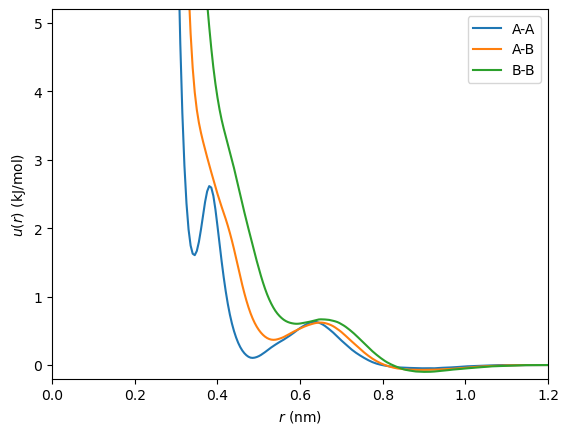

In [2]:
import matplotlib.pyplot as plt

r_plot = np.linspace(0, r_cut.value_in_unit(openmm.unit.nanometer), n_entries)
plt.plot(r_plot, u_aa.value_in_unit(openmm.unit.kilojoule_per_mole), label="A-A")
plt.plot(r_plot, u_ab.value_in_unit(openmm.unit.kilojoule_per_mole), label="A-B")
plt.plot(r_plot, u_bb.value_in_unit(openmm.unit.kilojoule_per_mole), label="B-B")
plt.xlim(r_plot[0], r_plot[-1])
plt.ylim(-0.2, 5.2)
plt.xlabel(r"$r\ (\rm{nm})$")
plt.ylabel(r"$u(r)\ (\rm{kJ/mol})$")
plt.legend()
plt.show()

## One Component

Suppose for a moment that we wish to simulate a pure fluid of component A only.  Then it is straightforward to set up a [CustomNonbondedForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomNonbondedForce.html) to evaluate the potential:

In [3]:
function = openmm.Continuous1DFunction(u_aa, 0, r_cut)

force = openmm.CustomNonbondedForce("table(r)")
force.addTabulatedFunction("table", function)
force.setNonbondedMethod(openmm.CustomNonbondedForce.CutoffPeriodic)
force.setCutoffDistance(r_cut)

You can then add the force to a System, and call `force.addParticle()` for each particle in the System.

There are a few things to keep in mind with this approach:

* Internally, [Continuous1DFunction](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Continuous1DFunction.html) uses natural cubic splines to interpolate between the table values.
* Continuous1DFunction assumes that the table points are uniformly spaced between the lower and upper bounds.  If this is not the case for your tabulated values, you could resample them, or pass an appropriate function of `r` as the argument to `table` in the custom expression.
* OpenMM converts tabulated function values to its [default unit system](https://docs.openmm.org/latest/userguide/theory/01_introduction.html#units), so results should be consistent as long as custom force expressions are dimensionally consistent.

## Multiple Components

The simplest way to implement tabulated functions between particles of multiple types is to use a [Continuous3DFunction](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.Continuous3DFunction.html) in place of the Continuous1DFunction.  We can use the $x$ and $y$ dimensions of the function to look up potentials given a pair of particle types, and the $z$ dimension to look up potential values.

In [4]:
n_types = 2

# For multidimensional tabulated functions, OpenMM expects values in column-major ("Fortran") order.
# Ensure that the array is symmetric with respect to exchange of particle types.
values = np.array([
    [u_aa.value_in_unit(openmm.unit.kilojoule_per_mole), u_ab.value_in_unit(openmm.unit.kilojoule_per_mole)],
    [u_ab.value_in_unit(openmm.unit.kilojoule_per_mole), u_bb.value_in_unit(openmm.unit.kilojoule_per_mole)],
]).flatten(order="F")

function = openmm.Continuous3DFunction(n_types, n_types, n_entries, values, 0, n_types - 1, 0, n_types - 1, 0, r_cut)

force = openmm.CustomNonbondedForce("table(type1, type2, r)")
force.addTabulatedFunction("table", function)
force.addPerParticleParameter("type")
force.setNonbondedMethod(openmm.CustomNonbondedForce.CutoffPeriodic)
force.setCutoffDistance(r_cut)

In this case, you must call `force.addParticle([particle_type])` to set the particle type index for each particle in the system.  (See the cookbook entry on [custom mixing rules](Customizing%20Lennard-Jones%20Mixing.ipynb) for another example of using particle types in OpenMM custom forces.)

In general, Continuous3DFunction will perform interpolation along all of its dimensions.  However, in this example, it will only have an effect along the $z$ dimension as long as all particle types are integers, since the bounds of the function have been set so that the samples in the $x$ and $y$ dimensions fall on integer values.

## Notes

Although this example shows a CustomNonbondedForce, you can also use tabulated functions with [CustomCentroidBondForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomCentroidBondForce.html), [CustomCompoundBondForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomCompoundBondForce.html), [CustomGBForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomGBForce.html), [CustomHbondForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomHbondForce.html), and [CustomManyParticleForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomManyParticleForce.html).  Note that [CustomBondForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomBondForce.html), [CustomAngleForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomAngleForce.html), and [CustomTorsionForce](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomTorsionForce.html) do not support tabulated functions, but their behavior can be fully replicated using CustomCompoundBondForce and the `distance(p1, p2)`, `angle(p1, p2, p3)`, and `dihedral(p1, p2, p3, p4)` functions supported in its custom energy expressions.

Instead of 3D functions taking pairs of particle types along with distance, 2D functions taking a bonded interaction type and a distance or angle can be used.  Use [CustomCompoundBondForce.addPerBondParameter()](https://docs.openmm.org/latest/api-python/generated/openmm.openmm.CustomCompoundBondForce.html#openmm.openmm.CustomCompoundBondForce.addPerBondParameter) to add a type index to each bonded term, and use the type index to look up the potential values in tables.  Pay close attention to the boundary conditions associated with each kind of bonded term:
* Typically, unlike pairwise potentials, bonds will not have cutoff distances beyond which the potential becomes 0.  You may wish to modify the custom energy expression using `select()` or another approach to define, *e.g.*, a linear extrapolation of the potential outside of the tabulated range.
* Angles should be in $[0,\pi]$.  Likewise, dihedrals should be in $[-\pi,\pi]$, and furthermore are periodic.  You can set `periodic=True` on OpenMM's continuous tabulated functions to ensure that there will be no discontinuity at the dihedral angle crossover point.

## Acknowledgements

1. The tabulated potentials used in this tutorial were generated following [this OpenMSCG tutorial](http://software.rcc.uchicago.edu/mscg/tutorials/lesson-01/README.html) extended to a binary mixture.  Thanks to Clay Batton for providing these data.